<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/ABC_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook validates the Fokker-Planck like equation derived in the paper *Craske J. et al. 2024* by computing each of the relevant terms numerically for the case of a scalar concentration evolving subject to an advection diffusion equation in a triply peridioc box via the ABC flow. To solve this equation we use the open source pseudo-spectral code Dedalus.



**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv


**Content**

First let's import everything we need to run the rest of the notebook.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
%matplotlib widget

Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t S + \left( \boldsymbol{u} \cdot \nabla \right) S = \kappa \nabla^2 S,
\end{equation}
over the time interval $t \in [0,1]$ in a triply-periodic box $\Pi^3$, with the velocity field given by the so called ABC flow
\begin{equation}
 \boldsymbol{u} = \left( A \sin(z) + C \cos(y), B \sin(x) + A \cos(z),  C \sin(y) + B \cos(x) \right).
\end{equation}
As an initial condition we prescribe a sharp interface,
\begin{equation}
S = \tanh(10(x + y + z)).
\end{equation}
NOTE: This takes about 3 minutes to run.

In [3]:
# Parameters
kappa = 0.1;  # Equivalent to Peclet number
A,B,C = 1,1,1;
Nx    = 64;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = .25
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y','z')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
zbasis = d3.RealFourier(coords['z'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis,zbasis))
x,y,z = dist.local_grids(xbasis,ybasis,zbasis)

# ABC flow
u['g'][0] = A*np.sin(z) + C*np.cos(y);
u['g'][1] = B*np.sin(x) + A*np.cos(z);
u['g'][2] = C*np.sin(y) + B*np.cos(x);

# Initial condition
S['g']    = np.tanh(10*(x + y + z))

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - kappa*div(grad_S) = -u@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(d3.Integrate(S**2)         , name='<S^2>' )
flow.add_property(d3.Integrate(grad_S@grad_S), name='<dS^2>')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 100 == 0:

            S2_avg = flow.grid_average('<S^2>')
            dS_avg = flow.grid_average('<dS^2>' )

            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
            logger.info('<S^2>=%f, <dS^2>    =%f'%(S2_avg,dS_avg))

        # Capture the last 5 snapshots
        if  solver.iteration == int(stop_sim_time/timestep) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(S,      layout='g',name='Scalar',scales=3/2)
            snapshots.add_task(grad_S, layout='g',name='grad_S',scales=3/2)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

INFO:subsystems:Building subproblem matrices 1/1024 (~0%) Elapsed: 0s, Remaining: 4m 25s, Rate: 3.9e+00/s


2024-04-05 16:25:16,750 subsystems 0/1 INFO :: Building subproblem matrices 1/1024 (~0%) Elapsed: 0s, Remaining: 4m 25s, Rate: 3.9e+00/s


INFO:subsystems:Building subproblem matrices 103/1024 (~10%) Elapsed: 4s, Remaining: 34s, Rate: 2.7e+01/s


2024-04-05 16:25:20,270 subsystems 0/1 INFO :: Building subproblem matrices 103/1024 (~10%) Elapsed: 4s, Remaining: 34s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 206/1024 (~20%) Elapsed: 6s, Remaining: 22s, Rate: 3.7e+01/s


2024-04-05 16:25:22,133 subsystems 0/1 INFO :: Building subproblem matrices 206/1024 (~20%) Elapsed: 6s, Remaining: 22s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 309/1024 (~30%) Elapsed: 8s, Remaining: 18s, Rate: 4.0e+01/s


2024-04-05 16:25:24,240 subsystems 0/1 INFO :: Building subproblem matrices 309/1024 (~30%) Elapsed: 8s, Remaining: 18s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 394/1024 (~38%) Elapsed: 10s, Remaining: 16s, Rate: 3.9e+01/s


2024-04-05 16:25:26,503 subsystems 0/1 INFO :: Building subproblem matrices 394/1024 (~38%) Elapsed: 10s, Remaining: 16s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 412/1024 (~40%) Elapsed: 10s, Remaining: 15s, Rate: 4.0e+01/s


2024-04-05 16:25:26,822 subsystems 0/1 INFO :: Building subproblem matrices 412/1024 (~40%) Elapsed: 10s, Remaining: 15s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 515/1024 (~50%) Elapsed: 12s, Remaining: 12s, Rate: 4.2e+01/s


2024-04-05 16:25:28,775 subsystems 0/1 INFO :: Building subproblem matrices 515/1024 (~50%) Elapsed: 12s, Remaining: 12s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 618/1024 (~60%) Elapsed: 14s, Remaining: 9s, Rate: 4.4e+01/s


2024-04-05 16:25:30,657 subsystems 0/1 INFO :: Building subproblem matrices 618/1024 (~60%) Elapsed: 14s, Remaining: 9s, Rate: 4.4e+01/s


INFO:subsystems:Building subproblem matrices 721/1024 (~70%) Elapsed: 16s, Remaining: 7s, Rate: 4.5e+01/s


2024-04-05 16:25:32,512 subsystems 0/1 INFO :: Building subproblem matrices 721/1024 (~70%) Elapsed: 16s, Remaining: 7s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 824/1024 (~80%) Elapsed: 18s, Remaining: 4s, Rate: 4.6e+01/s


2024-04-05 16:25:34,500 subsystems 0/1 INFO :: Building subproblem matrices 824/1024 (~80%) Elapsed: 18s, Remaining: 4s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 926/1024 (~90%) Elapsed: 20s, Remaining: 2s, Rate: 4.6e+01/s


2024-04-05 16:25:36,517 subsystems 0/1 INFO :: Building subproblem matrices 926/1024 (~90%) Elapsed: 20s, Remaining: 2s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 927/1024 (~91%) Elapsed: 20s, Remaining: 2s, Rate: 4.6e+01/s


2024-04-05 16:25:36,562 subsystems 0/1 INFO :: Building subproblem matrices 927/1024 (~91%) Elapsed: 20s, Remaining: 2s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 1024/1024 (~100%) Elapsed: 23s, Remaining: 0s, Rate: 4.5e+01/s


2024-04-05 16:25:39,268 subsystems 0/1 INFO :: Building subproblem matrices 1024/1024 (~100%) Elapsed: 23s, Remaining: 0s, Rate: 4.5e+01/s


INFO:__main__:Starting main loop


2024-04-05 16:25:39,308 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.000000e-03, dt=1.000000e-03


2024-04-05 16:25:41,699 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03


INFO:__main__:<S^2>=241.988738, <dS^2>    =5948.868191


2024-04-05 16:25:41,703 __main__ 0/1 INFO :: <S^2>=241.988738, <dS^2>    =5948.868191


INFO:__main__:Iteration=101, Time=1.010000e-01, dt=1.000000e-03


2024-04-05 16:26:29,395 __main__ 0/1 INFO :: Iteration=101, Time=1.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=205.156216, <dS^2>    =992.920235


2024-04-05 16:26:29,403 __main__ 0/1 INFO :: <S^2>=205.156216, <dS^2>    =992.920235


INFO:__main__:Iteration=201, Time=2.010000e-01, dt=1.000000e-03


2024-04-05 16:27:19,324 __main__ 0/1 INFO :: Iteration=201, Time=2.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=189.001976, <dS^2>    =677.828724


2024-04-05 16:27:19,327 __main__ 0/1 INFO :: <S^2>=189.001976, <dS^2>    =677.828724


INFO:solvers:Simulation stop time reached.


2024-04-05 16:27:43,209 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 250


2024-04-05 16:27:43,213 solvers 0/1 INFO :: Final iteration: 250


INFO:solvers:Final sim time: 0.25000000000000017


2024-04-05 16:27:43,217 solvers 0/1 INFO :: Final sim time: 0.25000000000000017


INFO:solvers:Setup time (init - iter 0): 43.07 sec


2024-04-05 16:27:43,220 solvers 0/1 INFO :: Setup time (init - iter 0): 43.07 sec


INFO:solvers:Warmup time (iter 0-10): 6.024 sec


2024-04-05 16:27:43,223 solvers 0/1 INFO :: Warmup time (iter 0-10): 6.024 sec


INFO:solvers:Run time (iter 10-end): 117.5 sec


2024-04-05 16:27:43,229 solvers 0/1 INFO :: Run time (iter 10-end): 117.5 sec


INFO:solvers:CPU time (iter 10-end): 0.03263 cpu-hr


2024-04-05 16:27:43,231 solvers 0/1 INFO :: CPU time (iter 10-end): 0.03263 cpu-hr


INFO:solvers:Speed: 1.022e+06 mode-stages/cpu-sec


2024-04-05 16:27:43,237 solvers 0/1 INFO :: Speed: 1.022e+06 mode-stages/cpu-sec


Having time integrated the transport equation for the solute concentration and generated snapshots of $S(x,y,z;t)$ at discrete time intervals on our numerical grid, we now use this data to validate the Fokker-Planck like equation
\begin{equation}
\partial_tf_S(s;t) = - \kappa \partial^2_s \left( \mathbb{E}[ |\nabla S|^2 |S=s]f_S(s;t) \right),
\end{equation}
which, subject to the knowledge of the expectation of the concentration gradient conditional on $S$, governs the time evolution of the probability density $f_S(s;t)$. We begin by loading the numerical snapshots saved

In [4]:
N_bins = 256

# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/Scalar'].dims[0][0][:]
x_data = file['tasks/Scalar'].dims[1][0][:]
y_data = file['tasks/Scalar'].dims[2][0][:]
z_data = file['tasks/Scalar'].dims[3][0][:]

S_data   = file['tasks/Scalar'][:,...]
dSx_data = file['tasks/grad_S'][:,0,...]
dSy_data = file['tasks/grad_S'][:,1,...]
dSz_data = file['tasks/grad_S'][:,2,...]
dS2_data = dSx_data**2 + dSy_data**2 + dSz_data**2;

We then use these data to estimate the terms in the Fokker-Planck like equation. To evaluate the left hand side we esimate the PDF $f_S$ (as a histogram) and then take its time derivative $\partial_t f_S$ using 4th order central differencing.

In [5]:
# PDF f_s
f_np2,s = np.histogram(S_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
f_np1,s = np.histogram(S_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

f_nm1,s = np.histogram(S_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
f_nm2,s = np.histogram(S_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

s       = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0];

# Time derivate df_s/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

For the right hand side we first compute the conditional expectation $\mathbb{E}[ |\nabla S|^2 |S=s]$ and then build the operator $\partial_s^2$ to compute its derivative.

In [6]:
# Expectation
f_SΦ,s,φ = np.histogram2d(S_data[-3,...].flatten(), dS2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
s = .5*(s[1:]+s[:-1]); ds = s[1] - s[0];
f_S =  np.sum(  f_SΦ,axis=1)*dφ     # f_S(s)
E   = (np.sum(φ*f_SΦ,axis=1)*dφ)/f_S; # E{Φ|S} = int_φ f_Φ|S(φ|s)*φ dφ

# Derivative
N = len(s)
L = np.zeros((N,N))
for i in range(N):

    L[i,i] = -2.

    if i < N-1:
        L[i,i+1] = 1
    if i > 1:
        L[i,i-1] = 1

L   *= 1./(ds**2);
L_inv= np.linalg.inv(L)

To compare the left and right hand sides of the Fokker-Planck like equation we then, rather than differentiating the potentially noisy numerically evaluated terms, opt to twice integrate the left hand side. Numerically this is achieved by inverting $L$ onto $\partial_t f_S$.

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:44,223 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:44,345 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:44,619 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


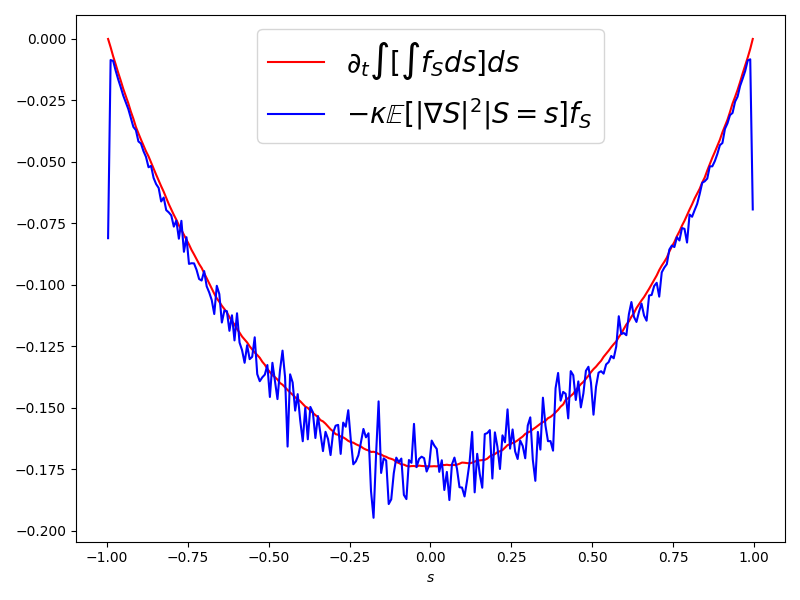

In [7]:
LHS =  L_inv@dfdt;
RHS = -kappa*E*f_S

# Plotting
fig = plt.figure(figsize=(8,6))

plt.plot(s,LHS,'r-',label=r'$\partial_t \int [\int f_S ds] ds$')
plt.plot(s,RHS,'b-',label=r'$-\kappa \mathbb{E}[ |\nabla S|^2 |S=s] f_S $')

plt.xlabel(r'$s$')
#plt.xlim([min(s),max(s)])
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('Equation_terms_HIST.png',dpi=200)
plt.show()

Plotting these terms above we see that the left and right hand sides balance thus numerically validating our equation for this example. Below we also plot the PDF conditional expectation and the scalar conecentration $S(x,y,z=0;t=1)$.

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:45,128 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:45,321 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-05 16:27:45,760 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


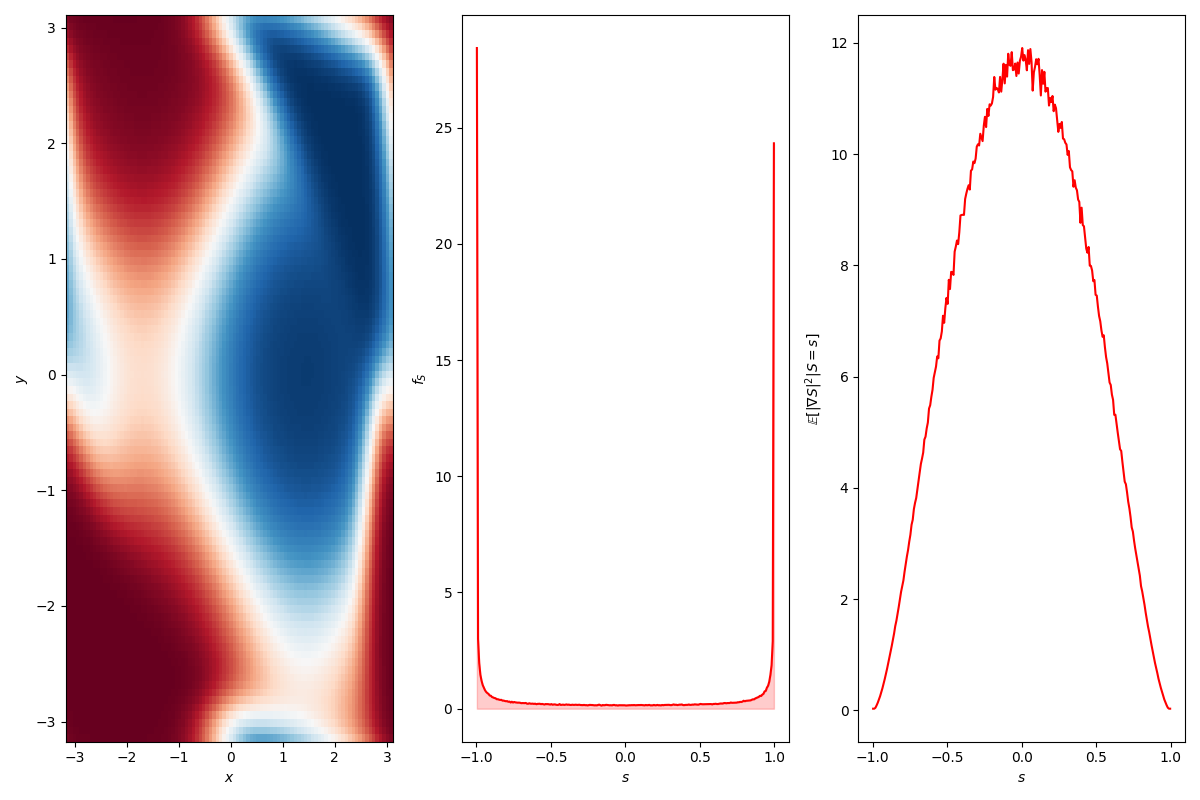

In [8]:
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].pcolormesh(x_data,y_data,S_data[-1,:,:,0],cmap='RdBu',norm='linear')
axs[0].set_ylabel(r'$y$')
axs[0].set_xlabel(r'$x$')

axs[1].plot(s,f_S,'r')
axs[1].fill_between(x=s,y1=f_S,color= "r",alpha= 0.2)
axs[1].set_ylabel(r'$f_S$')
axs[1].set_xlabel(r'$s$')

axs[2].plot(s,E,'r')
axs[2].set_ylabel(r'$\mathbb{E}[|\nabla S|^2 |S=s]$')
axs[2].set_xlabel(r'$s$')

plt.tight_layout()
plt.savefig('Field_And_PDF.png',dpi=200)
plt.show()